# 251. REINFORCE Algorithm

- Monte-Carlo method를 통해 구한 episodic sample 의 estimated return을 이용하여 policy parameter 𝜃를 update해 나가는 기법

- REINFORCE 갱신 규칙

$$\Delta\theta_t = \alpha\nabla_\theta\log{\pi_\theta}(s, a)G_t$$

- 따라서, Loss function 은 
$$-G_t\log{\pi_\theta}(s, a)$$

```
                log_prob = torch.log(pi(state_tensor))
                selected_log_probs = reward_tensor * \
                        torch.gather(log_prob, 1, action_tensor.unsqueeze(1)).squeeze()
                loss = -1 * selected_log_probs.mean()
```

In [14]:
# 2D physics library
!pip3 install -q box2d-py

# # install dependencies needed for recording videos
!apt-get install -y xvfb x11-utils > tmp
!pip install -q pyvirtualdisplay==0.2.*

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import gym
from IPython.display import HTML
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from base64 import b64encode

In [16]:
import gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical;
import time
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


<img src="https://miro.medium.com/max/1400/1*4RncZNj1ij5A5eMJpexhrw.png" width=700/>

### 환경 초기화

In [17]:
env = gym.make('LunarLander-v2')
#env = gym.make('CartPole-v1')

action_space = np.arange(env.action_space.n)
print(action_space)
print(env.observation_space.shape, env.action_space.n)

[0 1]
(4,) 2


### Policy Network 생성

In [18]:
# A differentiable policy parameterization pi(a|s,theta)
class PolicyNetwork(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        prob = F.softmax(self.fc3(x), dim=-1)
        return prob

#Initialize the parameters theta
pi = PolicyNetwork(input_dims=env.observation_space.shape, 
                              n_actions=env.action_space.n).to(device)
pi

PolicyNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

### hyper-parameters 설정, reward 계산 도우미 함수 생성

In [19]:
#Select step-size parameters 0<alpha<1
alpha = 0.001     
#Choose discount rate 0<gamma<1
gamma = 0.99
#Chose max number of episodes N
N = 10_000        
# Choose number of episodes to batch together for an update K >= 1
batch_size = 32

optimizer = optim.Adam(pi.parameters(), lr=alpha)

# rendering = True
total_rewards = []

def discount_rewards(rewards):
    Returns = []
    G = 0
    for r in rewards[::-1]:
        G = r + gamma * G
        Returns.append(G)
    # cumsum의 배열 방향을 반대로 한 다음 원래 순서로 되돌립니다.
    Returns = np.array(Returns[::-1], dtype=np.float64)
    # return Returns - Returns.mean()
    return Returns

### main algorithm 작성 / Train
- `CartPole-v0`의 경우 train 약 10 분 소요
- `LunarLander-v2` 의 경우 train 시간 약 1 시간 소요
- 시간 부족할 경우 이미 훈련된  `251_REINFORCE_LunarLander-V2.pth` 를 load 하여 시각화 Test 

In [20]:
start_time = time.time()
batch_rewards = []
batch_actions = []
batch_states = []
batch_counter = 1

# While episode n < N do: (training의 안정성 제고)
for episode in range(N):
   
    s = env.reset()

    # for K batches do:
    states = []
    rewards = []
    actions = []

    done = False
    # Generate an episode s0, a0, r0,...st,at,rt following policy pi(a|s,theta)
    while not done:
        probs = pi(torch.FloatTensor(s).to(device)).detach().cpu().numpy()
        a = np.random.choice(action_space, p=probs)
       
        s_, r, done, _ = env.step(a)
        
        states.append(s)
        rewards.append(r)
        actions.append(a)
  
        s = s_
        
#         if rendering and (episode > N * 0.98):
#             env.render()
        
        if done:
            # for each step in the eposide(t), discount reward do:
            # G_t = sum from t=1 to t=T {gamma^t * R_t}
            batch_rewards.extend(discount_rewards(rewards))
            batch_states.extend(states)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))
        
            # If batch is complete, update network
            if batch_counter == batch_size:    
                state_tensor = torch.FloatTensor(batch_states).to(device)
                reward_tensor = torch.FloatTensor(batch_rewards).to(device)
                action_tensor = torch.LongTensor(batch_actions).to(device)
                
                # Calculate policy loss for all episides in the batch 
                # L(theta) = -1/m sum(ln(G_t pi(a|s,theta)))))
                log_prob = torch.log(pi(state_tensor))
                selected_log_probs = reward_tensor * \
                        torch.gather(log_prob, 1, action_tensor.unsqueeze(1)).squeeze()
                
                loss = -1 * selected_log_probs.mean()
    
                # Update the policy: 
                # theta <- theta + alpha * grad[L(theat)]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_rewards = []
                batch_actions = []
                batch_states = []
                batch_counter = 1
                
    if episode % 100 == 0:
        avg_score = np.mean(total_rewards[-100:])
        print(f'episode {episode},  최근 100 episode 평균 reward {avg_score: .2f}')

env.close()

episode 0,  최근 100 episode 평균 reward  12.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


episode 100,  최근 100 episode 평균 reward  22.65
episode 200,  최근 100 episode 평균 reward  26.81
episode 300,  최근 100 episode 평균 reward  26.76
episode 400,  최근 100 episode 평균 reward  37.53
episode 500,  최근 100 episode 평균 reward  32.49
episode 600,  최근 100 episode 평균 reward  39.39
episode 700,  최근 100 episode 평균 reward  42.80
episode 800,  최근 100 episode 평균 reward  47.07
episode 900,  최근 100 episode 평균 reward  51.73
episode 1000,  최근 100 episode 평균 reward  58.69
episode 1100,  최근 100 episode 평균 reward  65.01
episode 1200,  최근 100 episode 평균 reward  81.08
episode 1300,  최근 100 episode 평균 reward  93.58
episode 1400,  최근 100 episode 평균 reward  112.36
episode 1500,  최근 100 episode 평균 reward  131.46
episode 1600,  최근 100 episode 평균 reward  145.91
episode 1700,  최근 100 episode 평균 reward  161.92
episode 1800,  최근 100 episode 평균 reward  176.64
episode 1900,  최근 100 episode 평균 reward  179.31
episode 2000,  최근 100 episode 평균 reward  184.73
episode 2100,  최근 100 episode 평균 reward  188.77
episode 2200, 

In [21]:
#torch.save(pi.state_dict(), '251_REINFORCE_LunarLander-V2.pth')

### reward 변화 시각화

duration =  12.173482994238535 minutes


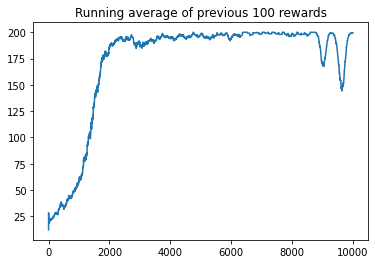

In [27]:
print("duration = ", (time.time() - start_time) / 60, "minutes")

running_avg = np.zeros(len(total_rewards))

for i in range(len(running_avg)):
    running_avg[i] = np.mean(total_rewards[max(0, i-100):(i+1)])
    
plt.plot(running_avg)
plt.title('Running average of previous 100 rewards')
plt.show()

### 이미 학습되어 저장된 model load

In [28]:
reload = False  # 저장된 모델 사용시  True 로 변경
if reload:
    pi = PolicyNetwork(input_dims=env.observation_space.shape, 
                                n_actions=env.action_space.n).to(device)
                                
    pi.load_state_dict(torch.load('251_REINFORCE_LunarLander-V2.pth'))

### Animate it with Video

In [29]:
display = Display(visible=False, size=(1400, 900))
_ = display.start()    # start display

def render_mp4(videopath: str) -> str:
  """
  지정된 경로에 있는 MP4 비디오의 b4 인코딩 버전을 포함하는 문자열을 가져옵니다.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [32]:
file = "train.mp4"
video = VideoRecorder(env, file)

# 시각화
state = env.reset()
done = False
while not done:
    env.render()
    video.capture_frame()

    with torch.no_grad():
        probs = pi(torch.FloatTensor(state).to(device)).detach().cpu().numpy()
        
    a = np.random.choice(action_space, p=probs)

    next_state, reward, done, _ = env.step(a)
    state = next_state

env.close()
video.close()

In [33]:
file = "train.mp4"

html = render_mp4(file)
HTML(html)